In [13]:

import dataclasses
import logging
from collections.abc import Sequence
from typing import Any

from levanter.data.text import LMMixtureDatasetConfig
from levanter.models.llama import LlamaConfig
from experiments.llama import llama_1_4b
from experiments.simple_train_config import SimpleTrainConfig
from marin.execution.executor import ExecutorStep, InputName

try:
    import pandas as pd
except ImportError:
    pd: Any = None

def _round_to_multiple(x, multiple):
    return int(multiple * round(x / multiple))

ENTITY = "stanford-mercury"
PROJECT = "marin"

def pull_metrics_from_wandb(runs: Sequence[str],
                            metrics: Sequence[str],
                            x_axis: str = "throughput/total_gflops",
                            summary_fields: Sequence[str] = ("parameter_count",)
                            ) -> pd.DataFrame:
    """
    Pulls metrics from wandb for a set of runs.

    Args:
        runs: runs to pull metrics from
        metrics: metrics to pull
        summary_fields: list of summary fields to include, defaults to ['parameter_count']

    Returns:
        DataFrame where rows are (run, step), columns are metrics and run properties
    """
    import wandb
    import pandas as pd

    print(f"Pulling metrics for runs {runs}")

    data = []
    for run_id in runs:
        api = wandb.Api()

        print("API: ", api)
        run = api.run(f"{ENTITY}/{PROJECT}/{run_id}")

        print(f"Pulling metrics for run {run.name}")
        run_data = {'run': run.name}

        # Add specified summary fields
        for field in summary_fields:
            run_data[field] = run.summary.get(field, None)

        history = run.history(keys=metrics, x_axis=x_axis)
        for i in range(len(history)):
            step_data = {f'{metric}': history[metric][i] for metric in metrics}
            step_data.update(run_data)  # Include run properties
            step_data['step'] = i
            data.append(step_data)

    return pd.DataFrame(data)

In [18]:
RUNS = [
    "tootsie-scaling-512-81c36c",
    "tootsie-scaling-768-d17a90",
    "tootsie-scaling-1024-f4e4be",
    "tootsie-scaling-1536-e2a6d8",
    "tootsie-scaling-2048-72c648", # these are trained for 200B tokens max, but have multiple checkpoints
]

In [20]:
# TODO: try out with eval/paloma/c4_en/loss for metric
tootsie_metrics = pull_metrics_from_wandb(RUNS, metrics=["eval/loss", "throughput/total_tokens"], summary_fields=["parameter_count"])

Pulling metrics for runs ['tootsie-scaling-512-81c36c', 'tootsie-scaling-768-d17a90', 'tootsie-scaling-1024-f4e4be', 'tootsie-scaling-1536-e2a6d8', 'tootsie-scaling-2048-72c648']
API:  <wandb.apis.public.api.Api object at 0x283cfde10>
Pulling metrics for run tootsie-scaling-512-81c36c
API:  <wandb.apis.public.api.Api object at 0x13807d950>
Pulling metrics for run tootsie-scaling-768-d17a90
API:  <wandb.apis.public.api.Api object at 0x138088290>
Pulling metrics for run tootsie-scaling-1024-f4e4be
API:  <wandb.apis.public.api.Api object at 0x13812c610>
Pulling metrics for run tootsie-scaling-1536-e2a6d8
API:  <wandb.apis.public.api.Api object at 0x283dba490>
Pulling metrics for run tootsie-scaling-2048-72c648


In [21]:
tootsie_metrics

,eval/loss,throughput/total_tokens,run,parameter_count,step
0,12.218495,0.000000e+00,tootsie-scaling-512-81c36c,248791552,0
1,3.011875,4.194304e+10,tootsie-scaling-512-81c36c,248791552,1
2,2.958518,8.388608e+10,tootsie-scaling-512-81c36c,248791552,2
3,2.945167,1.258291e+11,tootsie-scaling-512-81c36c,248791552,3
4,2.930376,1.677722e+11,tootsie-scaling-512-81c36c,248791552,4
5,2.885564,2.097110e+11,tootsie-scaling-512-81c36c,248791552,5
6,12.218498,0.000000e+00,tootsie-scaling-768-d17a90,461267712,0
7,2.844769,4.194304e+10,tootsie-scaling-768-d17a90,461267712,1
8,2.787246,8.388608e+10,tootsie-scaling-768-d17a90,461267712,2
9,2.764123,1.258291e+11,tootsie-scaling-768-d17a90,461267712,3


In [31]:
# Create a tuple of (N, D) where N is an array of parameter_count and D is an array of throughput/total_tokens

N = tootsie_metrics["parameter_count"].values
D = tootsie_metrics["throughput/total_tokens"].values
eval_losses = tootsie_metrics["eval/loss"].values

# remove places where D is 0 across all three arrays
N = N[D != 0]
eval_losses = eval_losses[D != 0]
D = D[D != 0]

x = (N, D)
y = eval_losses
print(len(N), len(D), len(eval_losses))

23 23 23


In [50]:
from utils import fit_power_law

power_law_params = fit_power_law(x, y, use_log_space=False)

In [51]:
power_law_params

(np.float64(1.0000000018496602),
 np.float64(1.0),
 np.float64(0.9999999652292553),
 np.float64(0.9999999998410559),
 np.float64(2.664603709767195))

In [37]:
!pip install scikit-learn 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 15.7 MB/s eta 0:00:00 0:00:01


Mean Squared Error: 0.029429058872780533


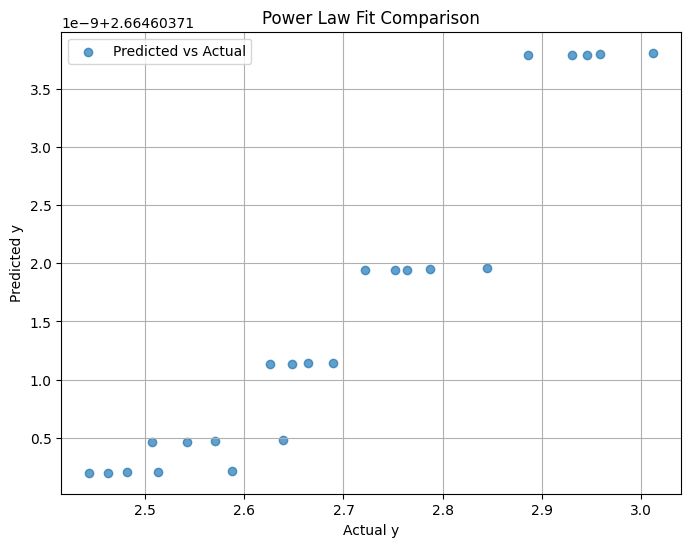

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Assume these are your fitted parameters
A, B, alpha, beta, E = power_law_params

# Using the fitted parameters to make predictions:
# According to the model, y_pred = A / (N^alpha) + B / (D^beta) + E
y_pred = A / (N**alpha) + B / (D**beta) + E

# Check how well predictions match the actual values:
residuals = y - y_pred
mse = np.mean(residuals**2)
print("Mean Squared Error:", mse)

# Scatter plot of actual vs predicted
plt.figure(figsize=(8,6))
plt.scatter(y, y_pred, alpha=0.7, label='Predicted vs Actual')
plt.xlabel("Actual y")
plt.ylabel("Predicted y")
plt.title("Power Law Fit Comparison")
plt.legend()
plt.grid(True)
plt.show()

# # If you want a more direct visualization of the fit, you might try plotting
# # the predicted surface as a function of N and D, or plot slices holding one
# # variable constant.

# # For instance, if you want to see how predictions vary with N for a fixed D:
# fixed_D = np.median(D)  # choose a representative D
# N_space = np.linspace(min(N), max(N), 100)
# y_line = A / (N_space**alpha) + B / (fixed_D**beta) + E

# plt.figure(figsize=(8,6))
# plt.scatter(N, y, alpha=0.7, label='Actual data')
# plt.plot(N_space, y_line, 'r-', label=f'Fit at D={fixed_D:.2f}')
# plt.xlabel("N")
# plt.ylabel("y")
# plt.title("Power Law Fit with Fixed D")
# plt.legend()
# plt.grid(True)
# plt.show()


In [53]:
PRED_RUN = "llama-8b-tootsie-0.001-19ad63"
tootsie_pred_run_metrics = pull_metrics_from_wandb([PRED_RUN], metrics=["eval/loss", "throughput/total_tokens"], summary_fields=["parameter_count"])

Pulling metrics for runs ['llama-8b-tootsie-0.001-19ad63']
API:  <wandb.apis.public.api.Api object at 0x13d402d10>
Pulling metrics for run llama-8b-tootsie-0.001-19ad63


In [54]:
tootsie_pred_run_metrics

,eval/loss,throughput/total_tokens,run,parameter_count,step
0,12.239254,0.000000e+00,llama-8b-tootsie-0.001-19ad63,8030261248,0
1,2.512954,2.097152e+10,llama-8b-tootsie-0.001-19ad63,8030261248,1
2,2.406456,4.194304e+10,llama-8b-tootsie-0.001-19ad63,8030261248,2
3,2.361698,6.291456e+10,llama-8b-tootsie-0.001-19ad63,8030261248,3
4,2.332177,8.388608e+10,llama-8b-tootsie-0.001-19ad63,8030261248,4
5,2.314757,1.048576e+11,llama-8b-tootsie-0.001-19ad63,8030261248,5
6,2.300089,1.258291e+11,llama-8b-tootsie-0.001-19ad63,8030261248,6
7,2.291108,1.468006e+11,llama-8b-tootsie-0.001-19ad63,8030261248,7
8,2.283978,1.677722e+11,llama-8b-tootsie-0.001-19ad63,8030261248,8
9,2.277572,1.887437e+11,llama-8b-tootsie-0.001-19ad63,8030261248,9


In [57]:
N_pred = tootsie_pred_run_metrics["parameter_count"].values
D_pred = tootsie_pred_run_metrics["throughput/total_tokens"].values

print(N_pred, D_pred)

print("Power law model parameters:", power_law_params)

# Apply the power law model to generate predictions
y_pred_new = A / (N_pred**alpha) + B / (D_pred**beta) + E

# If you have actual targets (e.g., 'eval/loss'), compare them
y_actual_new = tootsie_pred_run_metrics["eval/loss"].values

# Print a few predictions alongside the actual values
for i in range(min(10, len(y_actual_new))):
    print(f"Actual: {y_actual_new[i]:.4f}, Predicted: {y_pred_new[i]:.4f}")

[8030261248 8030261248 8030261248 8030261248 8030261248 8030261248
 8030261248 8030261248 8030261248 8030261248 8030261248 8030261248
 8030261248 8030261248 8030261248 8030261248 8030261248 8030261248
 8030261248 8030261248 8030261248 8030261248 8030261248 8030261248
 8030261248 8030261248 8030261248 8030261248 8030261248 8030261248
 8030261248 8030261248 8030261248 8030261248 8030261248 8030261248
 8030261248 8030261248 8030261248 8030261248 8030261248 8030261248
 8030261248 8030261248 8030261248 8030261248] [0.00000000e+00 2.09715200e+10 4.19430400e+10 6.29145600e+10
 8.38860800e+10 1.04857600e+11 1.25829120e+11 1.46800640e+11
 1.67772160e+11 1.88743680e+11 2.09715200e+11 2.30686720e+11
 2.51658240e+11 2.72629760e+11 2.93601280e+11 3.14572800e+11
 3.35544320e+11 3.56515840e+11 3.77487360e+11 3.98458880e+11
 4.19430400e+11 4.40401920e+11 4.61373440e+11 4.82344960e+11
 5.03316480e+11 5.24288000e+11 5.45259520e+11 5.66231040e+11
 5.87202560e+11 6.08174080e+11 6.29145600e+11 6.50117120e+

/var/folders/dd/zgr0v5mj6vzbtwp109vw8b780000gn/T/ipykernel_4241/1259256342.py:9: RuntimeWarning: divide by zero encountered in divide
  y_pred_new = A / (N_pred**alpha) + B / (D_pred**beta) + E


In [ ]:
# import jax.nn
# import wandb


# api = wandb.Api()

# filters = {
#     "duration": {"$gte": 60 * 10},
# }

# runs = api.runs(f"{entity}/{project}", filters)



# #%%
# # get final eval losses, parameter_count, batch_size and num steps, and seqlen for each run
# # key_of_interest = "eval/loss"
# # loss_curves = [[row[key_of_interest] for row in run.scan_history([key_of_interest], 1000)] for run in runs]


# def process_run(run):
#     return {
#         "loss": run.summary["eval/loss"],
#         "parameter_count": run.summary["parameter_count"],
#         "total_tokens": run.summary["throughput/total_tokens"],
#         "num_steps": run.config["trainer"]["num_train_steps"],
#         "seq_len": run.config["model"]["seq_len"],
#         "mlp_scale": run.config["model"].get("mlp_scale", 4),
#         "lr": run.config.get("optimizer", run.config["trainer"])["learning_rate"]
#     }

# data = [process_run(run) for run in runs]



# #%%
# # regress loss against parameter count and log total tokens

# import numpy as np
# import statsmodels.api as sm

# TRANSFORMS = {
#     "eval/loss": np.log,
#     "parameter_count": np.log,
#     "throughput/total_tokens": np.log,
#     "seq_len": np.log,
#     # "num_steps": np.log,
# }

# def prep_data(data: list[dict], target="eval/loss", transforms = TRANSFORMS):
#     # Extract and transform the data
#     data_matrix = []
#     target_data = [x[target] for x in data]
#     transform = transforms.get(target, None)
#     if transform:
#         target_data = transform(target_data)
    
#     keys = list(data[0].keys())
#     names = ["constant"]

#     for var in keys:
#         if var == target:
#             continue
#         names.append(var)
#         extracted_data = [x[var] for x in data]
#         transform = transforms.get(var, None)
#         if transform:
#             extracted_data = transform(extracted_data)
#         data_matrix.append(extracted_data)

#     # Create a design matrix
#     X = np.column_stack(data_matrix)
#     X = sm.add_constant(X, has_constant="add")
    
#     return names, X, target_data

# names, X, log_losses = prep_data(data, target="loss")

# # Perform the regression
# model = sm.OLS(log_losses, X)
# results = model.fit()

# # Print the results
# print(results.summary())



# #%%
# # import matplotlib.pyplot as plt
# # 
# # # 1. Scatter plot with regression plane (for two predictors)
# # fig = plt.figure(figsize=(10, 7))
# # ax = fig.add_subplot(111, projection='3d')
# # ax.scatter(log_parameter_counts, log_total_tokens, log_losses, c='b', marker='o')
# # xx1, xx2 = np.meshgrid(np.linspace(log_parameter_counts.min(), log_parameter_counts.max(), 100),
# #                        np.linspace(log_total_tokens.min(), log_total_tokens.max(), 100))
# # yy = results.params[0] + results.params[1] * xx1 + results.params[2] * xx2
# # ax.plot_surface(xx1, xx2, yy, alpha=0.5, color='r')
# # ax.set_xlabel('Log(Parameter Counts)')
# # ax.set_ylabel('Log(Total Tokens)')
# # ax.set_zlabel('Log(Loss)')
# # plt.show()

# #%%
# # a few test points:

# test_project = "levanter"

# filters = {
#     "duration": {"$gte": 60 * 60 * 2},
#     "tags": {"$in": ["pile"]},
#     # "id": {"$in": ["6ns1msth"]}
# }


# test_runs = api.runs(f"{entity}/{test_project}", filters)
# # id = "6ns1msth"
# id = "r88xoomz"
# test_runs = [api.run(f"{entity}/{test_project}/{id}")]

# def process_run_or_none(run):
#     try:
#         return process_run(run)
#     except:
#         return None

# test_data = [process_run_or_none(run) for run in test_runs if process_run_or_none(run) is not None and run.summary["eval/loss"] > 0.8 and run.summary["throughput/total_tokens"] > 100]


# print(len(test_data))



# #%%
# _, X_test, log_test_losses = prep_data(test_data, target="loss")
# # test the model on the test data
# train_losses_predicted = results.predict(X)
# log_losses_predicted = results.predict(X_test)

# print("train relative error: ", np.mean(np.abs(train_losses_predicted - log_losses) / log_losses))
# print("test relative error: ", np.mean(np.abs(log_losses_predicted - log_test_losses) / log_test_losses))

# print(np.exp(log_losses_predicted), np.exp(log_test_losses))


# #%%
# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(12, 6))
# sm.graphics.plot_partregress_grid(results, fig=fig)
# plt.show()
# #%%
# predicted = results.predict(X)
# residuals = log_losses - predicted
# log_parameter_counts = np.log([x["parameter_count"] for x in data])
# cmin = np.min(log_parameter_counts)
# cmax = np.max(log_parameter_counts)
# sc = plt.scatter(predicted, residuals, c=log_parameter_counts, cmap='viridis', vmin=cmin, vmax=cmax)
# plt.colorbar(sc, label='Log(Parameters)')
# plt.axhline(0, color='black', linestyle='--')

# # add test points
# predicted_test = results.predict(X_test)
# residuals_test = log_test_losses - predicted_test
# plt.scatter(predicted_test, residuals_test, color="red")

# # flip x axis
# plt.xlim(plt.xlim()[::-1])

# print(f"Min log param count: {cmin:.3f}, exp'd: {np.exp(cmin):.3e}")
# print(f"Max log param count: {cmax:.3f}, exp'd: {np.exp(cmax):.3e}")
# plt.xlabel('Predicted log(loss)')
# plt.ylabel('Residuals')
# plt.title('Residuals vs. Predicted')
# plt.show()

# #%%
# from tqdm import tqdm
# import jax
# import jaxopt
# import jax.numpy as jnp




# def inv_exp_predict(params, x):
#     (log_constant, log_scale, exponent) = params
#     # NOTE: chinchilla uses huber
#     z = jax.nn.logsumexp(log_scale - exponent * x, axis=1)
#     # log(exp(a) + exp(b)) = log(exp(a) * (1 + exp(b - a))) = a + log(1 + exp(b - a))
#     predicted = log_constant + jnp.log1p(jnp.exp(z - log_constant))
#     return predicted


# def mse_loss(params, y, x):
#     # ignore the scale
#     (log_constant, _, exponent) = params
#     targets = log_constant + jnp.einsum("ij,j->i", x, exponent)
    
#     return jnp.mean((y - targets) ** 2)

# # our predictor is:
# # log(exp(a dot x) + 

    
# new_X = X[:, 1:]

# loss_fn = chinchilla_loss

# min_loss = 1e9
# best_state = None

# seed = 0
# rng = jax.random.PRNGKey(seed)
# pbar = tqdm(range(10))
# for i in pbar:
#     this_rng, rng = jax.random.split(rng)
#     k_c, k_s, k_e = jax.random.split(rng, 3)
#     init_constant = jax.random.uniform(k_c, shape=(), minval=-1, maxval=1)
#     init_scale = jax.random.uniform(k_s, shape=(len(new_X[1]), ), minval=0, maxval=2)
#     init_exponent = jax.random.uniform(k_e, shape=(len(new_X[1]), ), minval=0, maxval=2)
    
#     state = jaxopt.LBFGS(loss_fn, tol=1E-9, maxiter=1000).run(
#         (init_constant, init_scale, init_exponent),
#         log_losses,
#         new_X
#     )
    
#     # print(state.params)
#     final_loss = loss_fn(state.params, log_losses, new_X)
#     if final_loss < min_loss:
#         min_loss = final_loss
#         best_state = state
#         pbar.set_postfix({"loss": min_loss})
    
    
    

# if False:
#     for alpha in jnp.linspace(0, 2, num=5, endpoint=True):
#         for beta in jnp.linspace(0, 2, num=5, endpoint=True):
#             for e in jnp.linspace(-1, 1, num=5, endpoint=True):
#                 for a in jnp.linspace(0, 25, num=6):
#                     for b in jnp.linspace(0, 25, num=6):
#                         print(".", end="", flush=True)
#                         init_constant = e
#                         init_scale = jnp.array([a, b])
#                         init_exponent = jnp.array([alpha, beta])
                        
#                         state = jaxopt.LBFGS(loss_fn, tol=1E-9, maxiter=1000).run(
#                             (init_constant, init_scale, init_exponent),
#                             log_losses,
#                             new_X
#                         )
                        
#                         # print(state.params)
#                         final_loss = loss_fn(state.params, log_losses, new_X)
#                         if final_loss < min_loss:
#                             min_loss = final_loss
#                             best_state = state
#                         # print(mse_loss(state.params, log_losses, new_X))
           
     
    
# print(best_state.params)
# print("Loss:", loss_fn(best_state.params, log_losses, new_X))
# # print(mse_loss(state.params, log_losses, new_X))

# log_constant, log_scale, exponent = best_state.params

# print(f"Constant: {jnp.exp(log_constant).item():.3f}")
# print("Params:")
# for i, (s, e) in enumerate(zip(jnp.exp(log_scale), exponent)):
#     name = names[i + 1]
#     print(f"  {i} {name}: {s.item():.3f}, {e.item():.3f}")

# print(jnp.exp(log_constant), jnp.exp(log_scale), exponent)
# #%%
# print(inv_exp_predict(best_state.params, X_test[:, 1:]), log_test_losses)
# #%% md
